[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Initial Data Shape: (47692, 2)
Number of duplicate tweets: 1675
Missing values per column:
 tweet_text            0
cyberbullying_type    0
dtype: int64
Data Shape after cleaning duplicates and NaNs: (46017, 2)

Label Distribution:
cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64


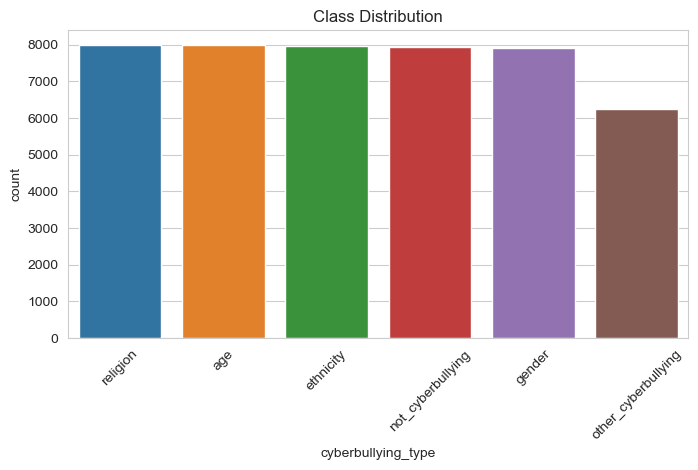

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


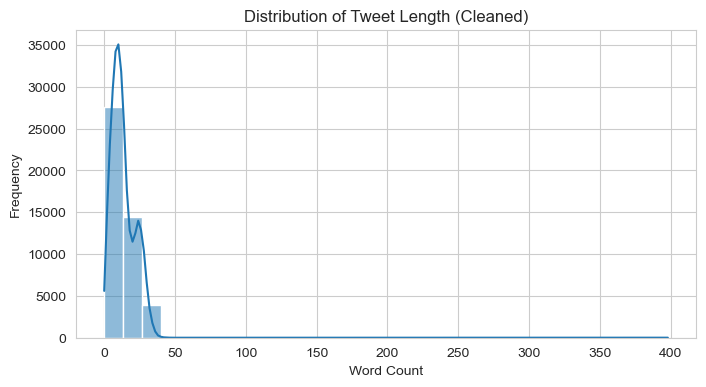

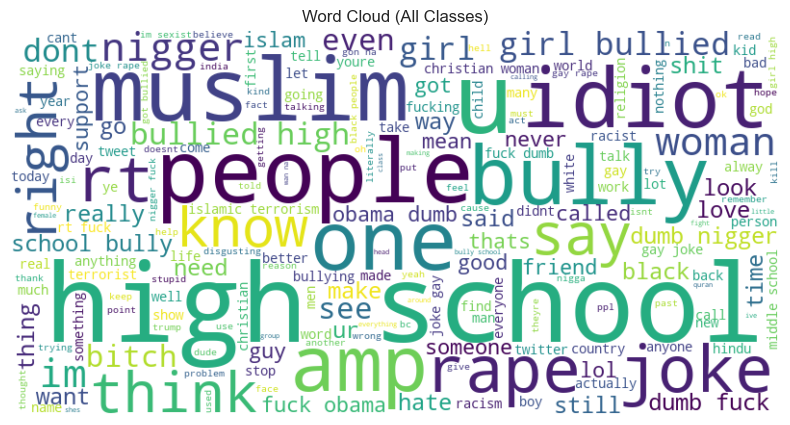

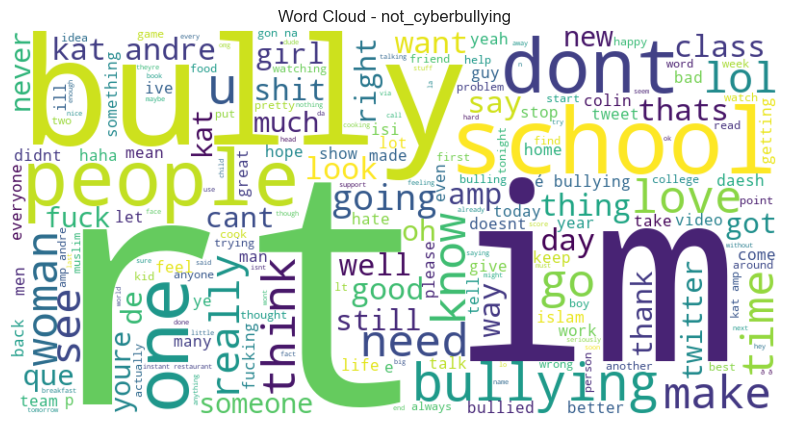

In [ ]:
############################################################
#  A. IMPORT LIBRARIES & SETUP
############################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional for advanced plots

import re
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# for word cloud
from wordcloud import WordCloud

# Setting a general style (optional)
sns.set_style("whitegrid")

############################################################
#  B. LOAD THE DATA
############################################################
# Adjust the file path as needed
df = pd.read_csv('cyberbullying_tweets.csv')
print("Initial Data Shape:", df.shape)

# Inspect the first few rows
df.head()

############################################################
#  C. DATA INSPECTION
############################################################
# Check for duplicates
num_duplicates = df.duplicated(subset='tweet_text').sum()
print(f"Number of duplicate tweets: {num_duplicates}")

# Drop duplicates if desired
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)

# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Drop rows with missing values in tweet text or cyberbullying_type if needed
df.dropna(subset=['tweet_text', 'cyberbullying_type'], inplace=True)

# Now see the new shape of the data
print("Data Shape after cleaning duplicates and NaNs:", df.shape)

# Check 'cyberbullying_type' distribution
label_counts = df['cyberbullying_type'].value_counts()
print("\nLabel Distribution:")
print(label_counts)

############################################################
#  D. BASIC TEXT CLEANING FUNCTIONS
############################################################
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text,
               remove_stopwords=True,
               perform_stemming=False,
               perform_lemmatization=True):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#\w+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        tokens = [w for w in tokens if w not in stop_words]

    # Stemming (optional)
    if perform_stemming:
        tokens = [stemmer.stem(w) for w in tokens]

    # Lemmatization (optional)
    if perform_lemmatization:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # Join the tokens back into a string
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Apply cleaning
df['clean_text'] = df['tweet_text'].apply(
    lambda x: clean_text(x,
                         remove_stopwords=True,
                         perform_stemming=False,
                         perform_lemmatization=True))

# Quick check on the transformations
df[['tweet_text','clean_text']].head()

############################################################
#  E. EXPLORATORY DATA ANALYSIS
############################################################

# 1. Label Distribution Plot
plt.figure(figsize=(8,4))
sns.countplot(x='cyberbullying_type', data=df,
              order=df['cyberbullying_type'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# 2. Distribution of Tweet Length (word count)
df['tweet_length'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Distribution of Tweet Length (Cleaned)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# 3. WordCloud for entire dataset
all_text = " ".join(df['clean_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud (All Classes)")
plt.show()

# 4. WordCloud per Class (optional: do for each label)
labels_unique = df['cyberbullying_type'].unique()
for lb in labels_unique:
    subset = df[df['cyberbullying_type'] == lb]
    text_subset = " ".join(subset['clean_text'].tolist())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text_subset)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud - {lb}")
    plt.show()

# 5. Top N-grams (example for unigrams/bigrams)
from collections import Counter

def get_top_n_grams(corpus, n_gram=1, n=None):
    """
    Return top n most common n-grams from a list of tokens.
    """
    tokens = [token for text in corpus for token in text.split()]
    n_grams = zip(*[tokens[i:] for i in range(n_gram)])
    freq_dict = Counter(n_grams)
    return freq_dict.most_common(n)

# Top 20 unigrams in the entire corpus
top_unigrams = get_top_n_grams(df['clean_text'], n_gram=1, n=20)
print("Top 20 unigrams:\n", top_unigrams)

# Convert to DataFrame for a barplot
unigram_df = pd.DataFrame(top_unigrams, columns=['unigram','count'])
unigram_df['unigram'] = unigram_df['unigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='unigram', data=unigram_df)
plt.title("Top 20 Unigrams")
plt.xlabel("Count")
plt.ylabel("Unigram")
plt.show()
